# MNIST digits dataset modelling

Firstly, we need to extract the data from downloaded files. To do that, I used the following functions:

In [1]:
import numpy as np
import pandas as pd
from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow as tf
def extract_mnist_images(image_filepath, num_images):
  with tf.io.gfile.GFile(image_filepath, "rb") as f:
    f.read(16)  # header
    buffer = f.read(28 * 28 * num_images)
    data = np.frombuffer(
        buffer,
        dtype=np.uint8,
    ).reshape(num_images, 28, 28, 1)
    return data


def extract_mnist_labels(labels_filepath, num_labels):
  with tf.io.gfile.GFile(labels_filepath, "rb") as f:
    f.read(8)  # header
    buffer = f.read(num_labels)
    labels = np.frombuffer(buffer, dtype=np.uint8).astype(np.int64)
    return labels

In [2]:
mnist_train_images = extract_mnist_images("train-images-idx3-ubyte", 60000)
mnist_test_images = extract_mnist_images("t10k-images-idx3-ubyte", 10000)

mnist_train_labels = extract_mnist_labels("train-labels-idx1-ubyte", 60000)
mnist_test_labels = extract_mnist_labels("t10k-labels-idx1-ubyte", 10000)

In [3]:
print("\nTrain images shape:", mnist_train_images.shape, "\nTrain labels shape:", mnist_train_labels.shape, "\nTest images shape:", mnist_test_images.shape, "\nTest labels shape:", mnist_test_labels.shape)


Train images shape: (60000, 28, 28, 1) 
Train labels shape: (60000,) 
Test images shape: (10000, 28, 28, 1) 
Test labels shape: (10000,)


In [4]:
#reshaping the images to vectors:
mnist_train_images = mnist_train_images.reshape(60000, 784)
mnist_test_images = mnist_test_images.reshape(10000, 784)

In [5]:
example_digit = mnist_train_images[100]

In [6]:
np.random.seed(42) # for reproducibility

## Models
### Support Vector Classifier 

In [7]:
# This can take a while, because SVC uses one versus one strategy 
# and in the end trains 45 different classification between every of the ten digits
should_run = True

In [8]:
from sklearn.svm import SVC

svm_classifier = SVC(random_state=42)

if should_run:
    svm_classifier.fit(mnist_train_images, mnist_train_labels) 

#### Model validatoion

In [9]:
from sklearn.model_selection import cross_val_score, cross_val_predict
if should_run:
    cross_val_score(svm_classifier, mnist_train_images, mnist_train_labels, cv=3, scoring="accuracy")

In [10]:
# accuracy is not the best way to measure model quality, confusion matrix is a better choice

from sklearn.metrics import precision_recall_curve
if should_run:
    y_scores = cross_val_predict(svm_classifier, mnist_train_images, mnist_train_labels, cv=3, method="decision_function")

In [11]:
y_predictions = [y_scores[row].argmax() for row in range(y_scores.shape[0])]

In [12]:
sum(y_predictions == mnist_train_labels) / mnist_train_labels.shape[0]

0.9743666666666667

In [13]:
import matplotlib.pyplot as plt
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")

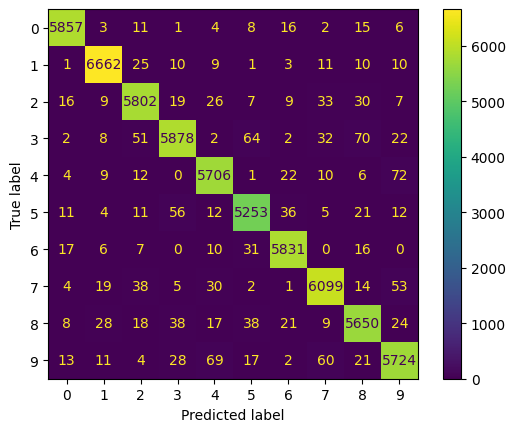

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_mx = confusion_matrix(mnist_train_labels, y_predictions)
ConfusionMatrixDisplay(confusion_mx).plot()

In [15]:
from sklearn.metrics import f1_score
F1_score = f1_score(mnist_train_labels, y_predictions, average=None)

In [16]:
print(F1_score.argmax(), F1_score.argmin())

0 9


Looking into the confusion matrix errors:

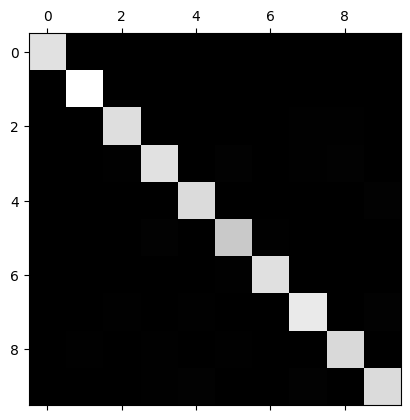

In [17]:
plt.matshow(confusion_mx, cmap=plt.cm.gray)

It is best to replace the diagonal with zero values since they dim the errors by their volume.
Additionally, there is a need to scale the errors by the number of images in the classes, so the smaller ones will be more visible.

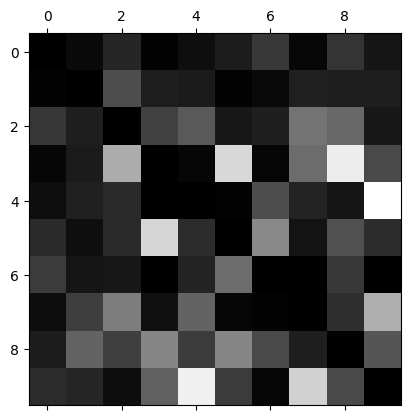

In [18]:
row_sums = confusion_mx.sum(axis=1, keepdims=True)
confusion_mx_normalized = confusion_mx / row_sums
np.fill_diagonal(confusion_mx_normalized, 0)
plt.matshow(confusion_mx_normalized, cmap=plt.cm.gray)

White squares mean that a column number was wrongly assigned to the true value in row. For example number 3 was incorrectly assigned as number 8 and number 9 was incorrectly assigned to a number that was actually 4. In the case of 4 and 9 simmilar errors occurred in the opposite direction.


Let's look into 4s and 9s more closely.

In [19]:
class_4 = 4
class_9 = 9
y_predictions = np.array(y_predictions)
X_44 = mnist_train_images[(mnist_train_labels == class_4) & (y_predictions == class_4)]
X_49 = mnist_train_images[(mnist_train_labels == class_4) & (y_predictions == class_9)]
X_94 = mnist_train_images[(mnist_train_labels == class_9) & (y_predictions == class_4)]
X_99 = mnist_train_images[(mnist_train_labels == class_9) & (y_predictions == class_9)]

In [20]:
import matplotlib as mpl
def plot_digits(examples, per_row=10):
    size = 28
    row_images = []
    
    per_row = min(len(examples), per_row)
    images = [instance.reshape(size,size) for instance in examples]
    n_rows = (len(examples) - 1) // per_row + 1
    n_empty = n_rows * per_row - len(examples)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * per_row : (row + 1) * per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary)
    plt.axis("off")

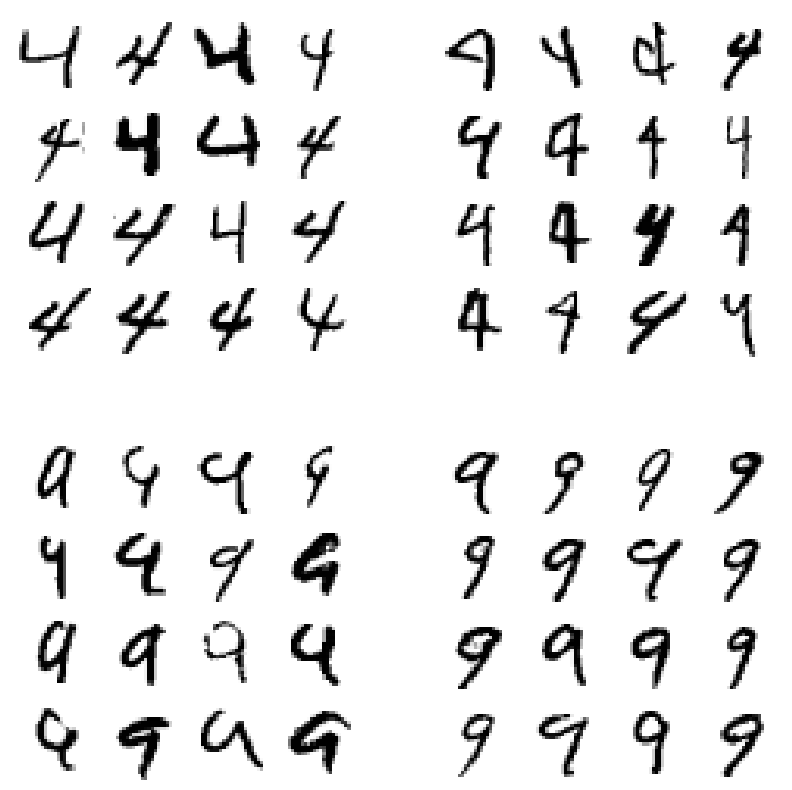

In [21]:
plt.figure(figsize=(10, 10))

plt.subplot(221, ); plot_digits(X_44[:16], per_row=4)
plt.subplot(222); plot_digits(X_49[:16], per_row=4)
plt.subplot(223); plot_digits(X_94[:16], per_row=4)
plt.subplot(224); plot_digits(X_99[:16], per_row=4)
plt.show()

The images on the left side are classified as 4s and the images on the right side are classified as 9s.
The numbers in the first row are actually all 4s and the numbers in the second row are all 9s.

Thanks to that comparison, we can see that some of the worngly assigned labels are actually a result of low quality image or an unusual way of writing the numbers. Probably even humans could have a problem with recognizing some of the numbers in bottom left corner as 4s.

### Training KNeigbors Classifier and selecting the best hyperparameters via grid search

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knc = KNeighborsClassifier()

parameters = [{'weights':['uniform', 'distance'], 'n_neighbors':[1, 3, 5]}]

if should_run:
    grid_search = GridSearchCV(knc, parameters, cv=5, verbose=3)
    grid_search.fit(mnist_train_images, mnist_train_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.970 total time=   8.2s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.971 total time=   8.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.969 total time=   8.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.969 total time=   8.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.968 total time=   8.1s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.970 total time=   8.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.971 total time=   8.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.969 total time=   8.1s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.969 total time=   8.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.968 total time=   8.0s
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  14.1s
[CV 2/5] END ....n_neighbors=3, weights=uniform;,

In [23]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [24]:
grid_search.best_score_

0.9711166666666665

In [25]:
from sklearn.metrics import accuracy_score

if should_run:
    predicted_labels_test = grid_search.predict(mnist_test_images)
    accuracy_score(mnist_test_labels, predicted_labels_test)

#### Data augmentation:

In [26]:
from scipy.ndimage.interpolation import shift

def shift_image(image, x_diff, y_diff):
    image = image.reshape((28, 28))
    new_image = shift(image, [y_diff, x_diff], cval=0, mode="constant")
    return new_image.reshape([-1])

/var/folders/t1/1qxx9snn6396k8pncnk12jrw0000gp/T/ipykernel_16486/1068487312.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [37]:
mnist_train_images_augmented = [number for number in mnist_train_images]
mnist_train_labels_augmented = [number for number in mnist_train_labels]

In [38]:
for x, y in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(mnist_train_images, mnist_train_labels):
        mnist_train_images_augmented.append(shift_image(image, x, y))
        mnist_train_labels_augmented.append(label) #labels are the same as for non-shifted images

In [39]:
mnist_train_images_augmented = np.array(mnist_train_images_augmented)
mnist_train_labels_augmented = np.array(mnist_train_labels_augmented)

In [40]:
new_knc = KNeighborsClassifier(**grid_search.best_params_)

In [41]:
new_knc.fit(mnist_train_images_augmented, mnist_train_labels_augmented)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [42]:
new_predictions = new_knc.predict(mnist_test_images)
accuracy_score(mnist_test_labels, new_predictions)

0.9763